### Imports

In [1]:
import torch
import torch.nn as nn
import torch.utils.data.dataset
import nn as defs
from tqdm import tqdm
import helper
from matplotlib import pyplot as plt
import pandas as pd
import pickle

## Preprocessing

In [5]:
# read only a subset of the data, using the parameters below
csv_file = "data/output.csv"
n_rows = 1600000
isWhite = True
fish_depth = 2

raws = pd.read_csv(csv_file, nrows=n_rows, usecols=["FEN", "Move"])
x = []
y = []

rows = raws.values.tolist()
with tqdm(total=len(rows)) as progress_bar:
    for row in rows:
        progress_bar.update(1)

        #board,move = helper.fen2pair(row[0], isWhite, depth=fish_depth)
        board = helper.fen2vec(row[0],True)
        move = row[1]

        if board is None or move is None:  # remove incorrect sides
            continue

        x.append(board)
        y.append(move)

y, move_to_int = helper.encode_moves(y)
num_classes = len(move_to_int)

data_x = torch.stack(x)
data_y = torch.tensor(y, dtype=torch.long)
print("Successfully Loaded Datasets!\n")
print(f"Size of Dataset: {len(data_y)}")

100%|██████████| 1600000/1600000 [27:10<00:00, 981.04it/s] 


: 

In [ ]:
# save preprocessed data
color = "white"
torch.save(data_x, f"data/processed_fens_{color}.pt")
torch.save(data_y, f"data/processed_moves_{color}.pt")
with open(f"move_to_int_{color}", "wb") as file:
    pickle.dump(move_to_int, file)

In [3]:
# load data
color = "white"
data_x = torch.load(f"data/processed_fens_{color}.pt")
data_y = torch.load(f"data/processed_moves_{color}.pt")
with open(f"models/vom_mti_{color}", "rb") as file:
    move_to_int = pickle.load(file)
num_classes = len(move_to_int)

EOFError: 

### Create Relevant Objects

In [8]:
# create dataset
dataset = defs.Dataset(data_x,data_y)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

# use GPU for model
LAWChess = defs.Model(num_classes=num_classes).to("cuda")

#define relevant training objects
criterion = nn.CrossEntropyLoss()

## Training

In [9]:
early_stopper = helper.EarlyStopper(patience=5, min_delta=1000)
optimizer = torch.optim.Adam(LAWChess.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode="min",
#     factor=0.1,
#     patience=10,
#     threshold=0.0001,
#     threshold_mode="abs",
# )

num_epochs = 6
train_losses = []
test_losses = []

# train the model
print("Training:")
with tqdm(total=num_epochs) as progress_bar:
    for epoch in range(num_epochs):

        train_loss = 0
        test_loss = 0
        progress_bar.update(1)

        # train
        LAWChess.train()
        for x, y in train_loader:
            x = x.to("cuda")
            y = y.to("cuda")

            # computing loss
            optimizer.zero_grad()
            pred = LAWChess(x)
            loss = criterion(pred, y)
            loss.backward()

            train_loss += loss.item()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(LAWChess.parameters(), max_norm=1.0)

            # update parameters with gd
            optimizer.step()

        # validate
        LAWChess.eval()
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to("cuda")
                y = y.to("cuda")

                pred = LAWChess(x)
                loss = criterion(pred, y)

                test_loss += loss.item()

        if early_stopper.early_stop(test_loss):
            break
        # scheduler.step(train_lossAvg / train_numBatch)
        print(f"train loss: {train_loss}")
        print(f"test loss: {test_loss}")
        train_losses.append(train_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))


Training:


 33%|███▎      | 2/6 [01:56<03:52, 58.15s/it]

train loss: 44644.03247141838
test loss: 9842.847222566605


 50%|█████     | 3/6 [03:19<03:25, 68.54s/it]

train loss: 37264.96123480797
test loss: 9343.768048524857


 67%|██████▋   | 4/6 [04:39<02:25, 72.87s/it]

train loss: 34900.72794127464
test loss: 9094.36685204506


 83%|████████▎ | 5/6 [05:58<01:14, 74.85s/it]

train loss: 33244.761944293976
test loss: 9007.553451538086


100%|██████████| 6/6 [07:17<00:00, 76.22s/it]

train loss: 31954.96480679512
test loss: 8993.733928442001


100%|██████████| 6/6 [08:40<00:00, 86.77s/it]

train loss: 30895.11457633972
test loss: 9007.236335039139


Train Loss: [4.4644032471418384, 3.7264961234807967, 3.4900727941274643, 3.3244761944293977, 3.195496480679512, 3.089511457633972]
Test Loss: [3.9371388890266417, 3.7375072194099426, 3.6377467408180237, 3.6030213806152345, 3.5974935713768006, 3.6028945340156557]


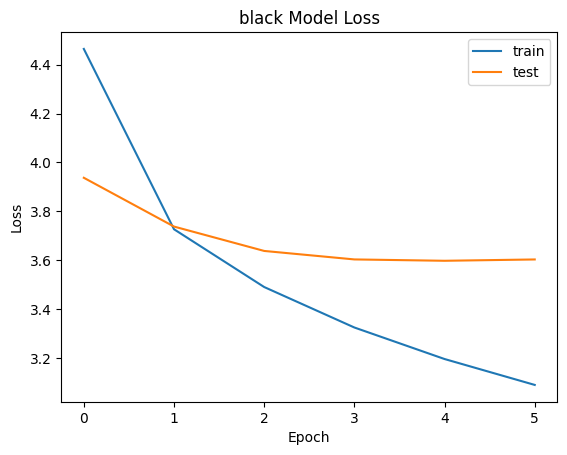

In [10]:
# map out loss
print(f"Train Loss: {train_losses}")
print(f"Test Loss: {test_losses}")
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.yscale("log")
plt.title(f"{color} Model Loss")
plt.legend()
plt.show()

## Save Model

In [8]:
torch.save(LAWChess.state_dict(), f"models/validation_optimized_model_{color}.pth")

In [9]:
with open(f"models/vom_mti_{color}", "wb") as file:
    pickle.dump(move_to_int, file)